In [1]:
import pandas as pd
import copy
import warnings
import numpy as np
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import os
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from datetime import datetime

now = datetime.now()
NOW_STR = f'{now.year}_{now.month}_{now.day}'

# Definir estilo do seaborn
sns.set_theme(style="whitegrid")

SEED = 42 # Muito importante manter a SEED igual em todos os modelos para garantir a consistência dos dados no ensemble
FOLDS = 5 # Muito importante manter o mesmo número de FOLDS em todos os modelos para garantir a consistência dos dados no ensemble

PATH = 'models/' # Caminho para os modelos
CLASSES = ["Enrolled","Graduate", "Dropout"]

scores = {} # Dicionário para armazenar os scores de estratégia de ensemble

# Listar todos os diretórios na pasta especificada
directories = [d for d in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, d))]
individual_models = directories.copy()
print(directories)

/home/rafael/anaconda3/envs/penidoEnv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['lgbm_1', 'rf_1', 'xgb_3', 'xgb_2', 'hgb_1', 'xgb_1', 'autoGluon_1', 'cat_2', 'lgbm_3', 'lgbm_2', 'faml_1', 'gb_1', 'cat_1']


# Getting Things Ready #

In [2]:
sub = pd.read_csv('src/test/sample_submission.csv', index_col='id')

In [3]:
import numpy as np
import pandas as pd

# Classe para ensemble de votação com base nas probabilidades(Soft Voting Classifier)
class SoftVotingClassifier:
    def __init__(self, classifiers, classes):

        self.classifiers = classifiers
        self.classes = classes
        self.nclasses = len(classes)

    def fit(self, X, y):
        pass
    
    def predict(self, df):

        prob_sum = np.zeros((len(df), self.nclasses))

        self.classes_cols = []
        for i, classe in enumerate(self.classes):
            self.classes_cols.append([col for col in df.columns if col.endswith(classe)])
            prob_sum[:,i] = df[self.classes_cols[i]].sum(axis=1)

        # Normaliza as probabilidades somadas
        prob_sum /= len(self.classifiers)
        
        # Predição final é a classe com a maior probabilidade
        # predictions = self.classes[np.argmax(prob_sum, axis=1)]
        predictions = np.argmax(prob_sum, axis=1)
        
        return predictions


In [4]:
# Constroi DataFrame com base nas predições dos modelos individuais - para treinamento
def build_dfs(directories):

    folds = []

    for i in range(FOLDS):

        models_predictions = []

        for model in directories:
            # Carregar o modelo
            df = pd.read_csv(f'{PATH}{model}/oof/fold_{i+1}.csv')
            columns = df.columns
            df.columns = [f'{model}_{col}' for col in columns]
            df.rename(columns={f'{model}_true': 'true_label'}, inplace=True)
            models_predictions.append(df)

        # Concatenar as previsões de todos os modelos
        df = pd.concat(models_predictions, axis=1)
        df = df.loc[:, ~df.columns.duplicated(keep='last')] # Remover colunas duplicadas(true label)
        folds.append(df)


    return folds

In [5]:
# Constroi DataFrame com base nas predições dos modelos individuais - para teste
def build_test_set(directories):

    models_predictions = []

    for model in directories:
        # Carregar o modelo
        df = pd.read_csv(f'{PATH}{model}/test/test_pred.csv')
        columns = df.columns
        df.columns = [f'{model}_{col}' for col in columns]
        models_predictions.append(df)

    # Concatenar as previsões de todos os modelos
    df = pd.concat(models_predictions, axis=1)

    return df

In [6]:
# Estratégia de Validação Cruzada
def cross_validation(model, folds, target_column='true_label', scoring=accuracy_score, verbose=1, models=directories.copy()):
    scores = []
    models.append(target_column)
    
    for i, fold in enumerate(folds):

        if verbose == 1:
            print(f"Fold {i + 1}")
        
        # Separando o conjunto de treino e validação
        train_folds = folds[:i] + folds[i+1:]
        val_fold = fold
        
        # Concatenando os DataFrames de treino
        train_df = pd.concat(train_folds, ignore_index=True)

        regex_pattern = '^' + '|^'.join(models)
        train_df = train_df.filter(regex=regex_pattern)
        val_fold = val_fold.filter(regex=regex_pattern)

        # Separando as features e o target
        X_train = train_df.drop(columns=[target_column])
        y_train = train_df[target_column]
        
        X_val = val_fold.drop(columns=[target_column])
        y_val = val_fold[target_column]
        
        # Treinando o modelo
        model.fit(X_train, y_train)
        
        # Fazendo previsões no conjunto de validação
        y_pred = model.predict(X_val)
        
        # Calculando a métrica de avaliação
        score = scoring(y_val, y_pred)
        scores.append(score)
                
    if verbose == 1:
        print(f"Score: {np.mean(scores)}")
    
    return scores

In [7]:
# Plota um resumo da performance de cada modelo, incluindo ensembles
def summarize_models(scores, models, folds, encoder, scoring=accuracy_score):

    models_scores = {}
    
    for model in models:
        model_scores = []

        for fold in folds:
            model_cols = [col for col in fold.columns if col.startswith(model)]
            y_true = fold['true_label'].map(encoder)
            y_pred = fold[model_cols].idxmax(axis=1).apply(lambda x: x.split('_')[-1])

            score = scoring(y_true, y_pred)
            model_scores.append(score)
        
        models_scores[model] = model_scores

    scores.update(models_scores)
    
    means = {key: np.mean(value) for key, value in scores.items()}

    # Preparar dados para o gráfico
    keys = list(means.keys())
    values = list(means.values())

    # Criar DataFrame e ordenar pelos valores de forma decrescente
    data = pd.DataFrame({'Keys': keys, 'Mean Values': values})
    data = data.sort_values(by='Mean Values', ascending=False)

    # Plotar gráfico de barras horizontal
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x='Mean Values', y='Keys', data=data, palette='viridis')

    # Adicionar valores ao lado de cada barra
    for index, value in enumerate(data['Mean Values']):
        ax.text(value, index, f'{value:.4f}', color='black', va="center")

    plt.xlim(min(values) * 0.995, max(values) * 1.001)  # Ajustar a escala do eixo x para ser 10% maior que o valor máximo

    plt.xlabel('Score')
    plt.ylabel('Model')
    plt.title('Accuracy Score of Models')

    plt.show()

In [8]:
# Faz predição final
def predict_test(name, model, folds, X_test, encoder, sample_sub):

    train = pd.concat(folds, ignore_index=True)

    y_train = train.pop('true_label')
    X_train = train

    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    map_func = np.vectorize(lambda x: encoder[x])
    pred_mapped = map_func(pred)

    sample_sub['Target'] = pred_mapped

    os.makedirs('submission', exist_ok=True)

    sample_sub.to_csv(f'submission/{name}-{NOW_STR}.csv')

    return sample_sub

# Ensemble techniques #

In [9]:
train_folds = build_dfs(directories)
test = build_test_set(directories)

for fold in train_folds:
    fold['true_label'] = fold['true_label'].replace({"Enrolled": 0, "Graduate": 1, "Dropout": 2})

encoder = {0: "Enrolled", 1: "Graduate", 2: "Dropout"}

/tmp/ipykernel_15133/4163267972.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fold['true_label'] = fold['true_label'].replace({"Enrolled": 0, "Graduate": 1, "Dropout": 2})


## Stacking ##

### Logistic Regression ###
The predictions of various individual classifiers are used as features to train a second model, here a logistic regression model. The goal of Stacking is to combine the strengths of different classifiers to improve the predictive performance of the final model.

In [10]:
models_logreg = ['lgbm_1', 'xgb_2', 'xgb_1', 'autoGluon_1', 'cat_2', 'cat_1'] # Obtained with Optuna. Following in the notebook
logreg_best_params = {'C': 1.079114726976617, 'solver': 'lbfgs', 'multi_class': 'multinomial'} # Obtained with Optuna. Following in the notebook

logreg = LogisticRegression()

scores['logreg_ensemble'] = cross_validation(logreg, train_folds, models=models_logreg)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Score: 0.8340045664260309


### XGBClassifier ###
Using such a complex model will likely lead the solution to overfitting.

In [11]:
xgb = XGBClassifier(random_state=42)

scores['xgb_ensemble']  = cross_validation(xgb, train_folds)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Score: 0.8304835655872089


## Voting Classifiers ##

### Soft Voting ###
Each base classifier provides a probability for each class, and these probabilities are weighted and summed. The class with the highest sum of probabilities is chosen as the final prediction.

In [12]:
svc_folds = copy.deepcopy(train_folds) # Copying to be able to apply the linear coefficients of each model

models_logreg = ['lgbm_1', 'hgb_1', 'xgb_1', 'autoGluon_1', 'cat_2', 'lgbm_3', 'lgbm_2', 'faml_1', 'gb_1', 'cat_1'] # Obtained with Optuna. Following in the notebook
coef = {'lgbm_1': 0.1544844841427367, 'hgb_1': 0.06040630268248156, 'xgb_1': 0.17757833638227385, 'autoGluon_1': 0.013127296376022647, 'cat_2': 0.05932135847011121, 'lgbm_3': 0.16405715859889958, 'lgbm_2': 0.03415119805549105, 'faml_1': 0.1801813999837779, 'gb_1': 0.010108580880040961, 'cat_1': 0.14658388442816445} # Obtained with Optuna. Following in the notebook

# Applying linear coefficients of each model
for f in svc_folds:
    for model in models_logreg:

        regex_pattern = '^' + '|^'.join([model])
        cols = f.filter(regex=regex_pattern).columns
        f[cols] = f[cols] * coef[model]

svc = SoftVotingClassifier(directories, CLASSES)

scores['svc_ensemble']  = cross_validation(svc, svc_folds, models=models_logreg)

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5
Score: 0.8340786992262743


# Models Scoring #

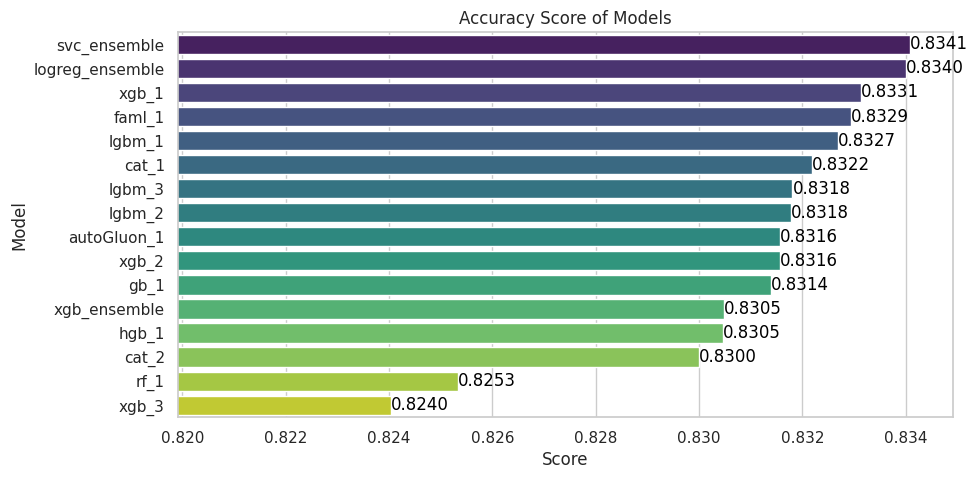

In [13]:
summarize_models(scores, individual_models, train_folds, encoder)

# Optimizing hyperparameters #                                                              

## Selecting the best subset of classifiers ##

In [19]:
def objective(trial):

    modelos = directories.copy()
    folds = copy.deepcopy(train_folds)
    
    to_rmv = []

    for modelo in modelos:

        if trial.suggest_categorical(f"{modelo}", [0, 1]) == 0:
            to_rmv.append(modelo)


    modelos = list(set(modelos) - set(to_rmv))
    modelos.append('true_label')
    
    logreg = LogisticRegression()
    score = cross_validation(logreg, folds, models=modelos)
        
    return np.mean(score)

warnings.filterwarnings("ignore")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2000)

In [ ]:
# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros: ", study.best_params)
print("Melhor acurácia: ", study.best_value)

## Selecting the best hyperparameters for logistic regression stacking ##

In [14]:
# Definir a função objetivo
def objective(trial):

    folds = copy.deepcopy(train_folds)

    # Hiperparâmetros do LogisticRegression a serem otimizados
    C = trial.suggest_loguniform('C', 1e-5, 10)
    solver = trial.suggest_categorical('solver', ['sag', 'saga', 'lbfgs', 'newton-cg'])
    multi_class = trial.suggest_categorical('multi_class', ['auto', 'multinomial'])
    
    # Definir o modelo
    model = LogisticRegression(C=C, solver=solver, multi_class=multi_class, max_iter=10000, random_state=42)
    
    score = np.mean(cross_validation(model, folds, verbose=0, models=models_logreg))
    
    return score

warnings.filterwarnings("ignore")

# Criar um estudo com um callback para early stopping
study = optuna.create_study(direction='maximize')

# Realizar a otimização
study.optimize(objective, n_trials=10_000)

[I 2024-07-01 22:35:17,319] A new study created in memory with name: no-name-9656e75b-9bd0-42d4-935b-cc49f383bb20
[I 2024-07-01 22:35:23,173] Trial 0 finished with value: 0.83295443481339 and parameters: {'C': 0.0008217313786887475, 'solver': 'saga', 'multi_class': 'auto'}. Best is trial 0 with value: 0.83295443481339.
[I 2024-07-01 22:35:29,167] Trial 1 finished with value: 0.8328926629491822 and parameters: {'C': 0.0006856576674363671, 'solver': 'saga', 'multi_class': 'auto'}. Best is trial 0 with value: 0.83295443481339.
[I 2024-07-01 22:35:35,171] Trial 2 finished with value: 0.8332262342211856 and parameters: {'C': 0.012729956000838613, 'solver': 'saga', 'multi_class': 'multinomial'}. Best is trial 2 with value: 0.8332262342211856.
[I 2024-07-01 22:35:37,085] Trial 3 finished with value: 0.8262088918363224 and parameters: {'C': 4.7563049195835575e-05, 'solver': 'newton-cg', 'multi_class': 'auto'}. Best is trial 2 with value: 0.8332262342211856.
[I 2024-07-01 22:35:39,796] Trial 4 

In [15]:
# Imprimir os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros: ", study.best_params)
print("Melhor acurácia: ", study.best_value)

Melhores hiperparâmetros:  {'C': 1.4945010427119048, 'solver': 'sag', 'multi_class': 'auto'}
Melhor acurácia:  0.8336092248161439


## Selecting optimal linear coefficients for each model in the Soft Voting Classifier ##

In [41]:
def objective(trial):

    modelos = models_logreg.copy()
    current_folds = copy.deepcopy(train_folds)
    
    coeficientes = []

    for modelo in modelos:
        coeficientes.append(trial.suggest_float(f'{modelo}', 0.0, 1.0))

    coeficientes = np.array(coeficientes)
    coeficientes /= np.sum(coeficientes)  # Normaliza os coeficientes

    for f in current_folds:
        for i, model in enumerate(modelos):

            regex_pattern = '^' + '|^'.join([model])
            cols = f.filter(regex=regex_pattern).columns
            f[cols] = f[cols] * coeficientes[i]
            

    svc = SoftVotingClassifier(modelos, CLASSES)
    score = cross_validation(svc, current_folds, verbose=0, models=modelos)
    
    return np.mean(score)

In [43]:
warnings.filterwarnings("ignore")

sampler = TPESampler(seed=SEED)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=10000)

[I 2024-06-26 21:50:53,758] A new study created in memory with name: no-name-c8c39f43-bcaf-4f3d-b514-b95839438d58
[I 2024-06-26 21:50:53,986] Trial 0 finished with value: 0.8330656252373909 and parameters: {'lgbm_1': 0.3745401188473625, 'hgb_1': 0.9507143064099162, 'xgb_1': 0.7319939418114051, 'autoGluon_1': 0.5986584841970366, 'cat_2': 0.15601864044243652, 'lgbm_3': 0.15599452033620265, 'lgbm_2': 0.05808361216819946, 'faml_1': 0.8661761457749352, 'gb_1': 0.6011150117432088, 'cat_1': 0.7080725777960455}. Best is trial 0 with value: 0.8330656252373909.
[I 2024-06-26 21:50:54,212] Trial 1 finished with value: 0.8327814595514258 and parameters: {'lgbm_1': 0.020584494295802447, 'hgb_1': 0.9699098521619943, 'xgb_1': 0.8324426408004217, 'autoGluon_1': 0.21233911067827616, 'cat_2': 0.18182496720710062, 'lgbm_3': 0.18340450985343382, 'lgbm_2': 0.3042422429595377, 'faml_1': 0.5247564316322378, 'gb_1': 0.43194501864211576, 'cat_1': 0.2912291401980419}. Best is trial 0 with value: 0.8330656252373

In [45]:
# Imprimir os melhores hiperparâmetros encontrados

# Normaliza os valores
total = sum(study.best_params.values())
normalized_params = {k: v / total for k, v in study.best_params.items()}

print("Melhores hiperparâmetros: ", normalized_params)
print("Melhor acurácia: ", study.best_value)

Melhores hiperparâmetros:  {'lgbm_1': 0.1544844841427367, 'hgb_1': 0.06040630268248156, 'xgb_1': 0.17757833638227385, 'autoGluon_1': 0.013127296376022647, 'cat_2': 0.05932135847011121, 'lgbm_3': 0.16405715859889958, 'lgbm_2': 0.03415119805549105, 'faml_1': 0.1801813999837779, 'gb_1': 0.010108580880040961, 'cat_1': 0.14658388442816445}
Melhor acurácia:  0.834115765244815


# Test Prediction # 

In [ ]:
predict_test('logreg_tuned', logreg, train_folds, test, encoder, sub)